# Do the numerical "fits" to the 70 and 160 micron band intensities match the more direct color-temperature solutions?
### I want to compare the fitted temperature values I used in the paper to the values from the referee's suggested direct color temperature approach. If the temperatures are correct, then the column densities, and thus the estimated shell mass, should be fine too.

I'm trying to address the March 2021 RCW 49 paper ref's comments about the PACS 70 and 160 "fit". I want to investigate the direct solution using the intensity ratio. I have grids of PACS and SPIRE intensities for a range of temperature, $\tau$, and $\beta$ that I made for Lee for HELPSS, so I'll try using those to learn about this and maybe draft a plot that can help.

Caveat that the $\beta$ grid I made for Lee doesn't include $\beta=2$, which was my assumed power law for the RCW 49 fit. This present calculation is just to get the right general idea for now, so I'll use $\beta=1.7$ results, and then if I really want to make a better plot, I'll need to make a new grid for $\beta=2$. The general result (whether or not my fits agree with the color-temperature approach) should be the same.

In [1]:
# Created: March 9, 2021
__author__ = "Ramsey Karim"

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
grid_fn = os.path.abspath('/home/ramsey/Documents/Research/Filaments/tb_grid_3D_2020-10-08.pkl')
assert os.path.exists(grid_fn)
with open(grid_fn, 'rb') as f:
    grid_dict = pickle.load(f)
print("Dictionary keys:", ", ".join(list(grid_dict.keys())))
print()
print(grid_dict['README'])

Dictionary keys: PACS70um, PACS100um, PACS160um, SPIRE250um, SPIRE350um, SPIRE500um, tau160, T, beta, README

## README ##
This is a 3D grid of log10(tau(160micron)), T [K], beta
Return value is a dictionary; check the keys

tau_range = np.arange(-4.1, -0.398, 0.002)
T_range = np.arange(6, 60.01, 0.05)
b_range = np.array([1.675, 1.70, 1.725, 1.75, 1.775])

## END ##



In [3]:
# Use the beta = 1.7 grid
idx_beta17 = 1
assert np.all(grid_dict['beta'][:, :, idx_beta17] == 1.7)
tau = grid_dict['tau160'][:, :, idx_beta17]
T = grid_dict['T'][:, :, idx_beta17]
beta = grid_dict['beta'][:, :, idx_beta17]
# Blue-to-red ratio
br = grid_dict['PACS70um'][:, :, idx_beta17] / grid_dict['PACS160um'][:, :, idx_beta17]
print("Full tau/T/beta grid shape:", grid_dict['tau160'].shape)
print("tau/T grid shape:", tau.shape)

Full tau/T/beta grid shape: (1851, 1081, 5)
tau/T grid shape: (1851, 1081)


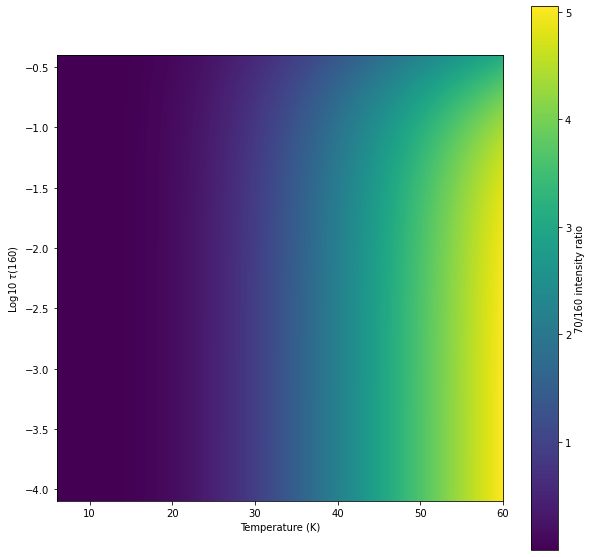

In [4]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(br, origin='lower', extent=[6, 60, -4.1, -0.398], aspect=(60-6)/(-0.398+4.1))
plt.xlabel("Temperature (K)"), plt.ylabel("Log10 $\\tau(160)$")
plt.colorbar(label="70/160 intensity ratio");

Looks like the intensity ratio (blue-to-red, in this case) is a simple, smooth function of temperature at low values of $\tau$, in the optically thin regime, as expected. Now I can grab a single $\tau$ (optically thin) array of temperatures and blue-to-red ratios and plot those against each other.

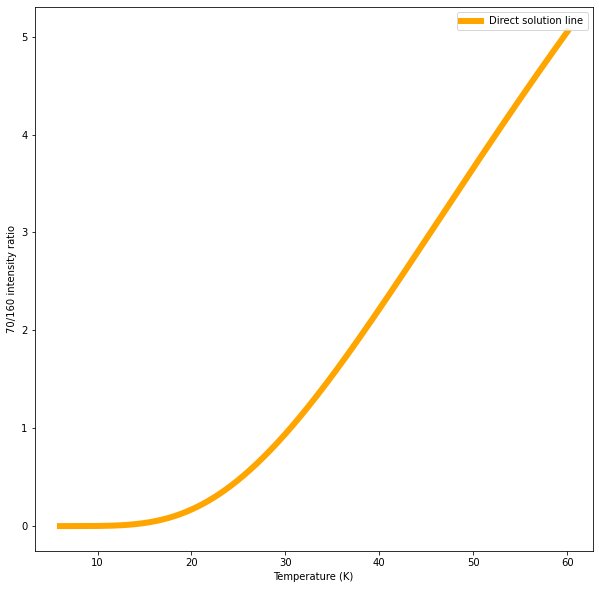

In [5]:
T_thin = T[0, :]
br_thin = br[0, :]
assert tau[0, 0] < 4

plt.figure(figsize=(10, 10))
plt.plot(T_thin, br_thin, lw=6, color='orange', label="Direct solution line")
plt.legend()
plt.xlabel("Temperature (K)"), plt.ylabel("70/160 intensity ratio");
# plt.yscale('log')#, plt.xscale('log');

Load in the RCW 49 ($T$, $\tau$) solution from `mantipython` (my Python code that I used to make the fits for the paper) and overplot those points and intensity ratios over this plot. Of course, the solution for the paper was for $\beta=2$, and the solution I'm loading here is for $\beta=1.7$, but I think the general agreement between the methods should be the same, regardless of the particular $\beta$ power law.

In [6]:
from astropy.io import fits
# Use the 1.7! It's at the 500 grid, but good enough for my purposes
soln_fn = os.path.abspath("/home/ramsey/Documents/Research/Feedback/rcw49_data/herschel/RCW49large_2p_2BAND_500grid_beta1.7.fits")
assert os.path.exists(soln_fn)
with fits.open(soln_fn) as hdul:
    for i in range(len(hdul)):
        if i == 0:
            continue
        print(hdul[i].header['EXTNAME'])
    T_img = hdul['solutionT'].data
    tau_img = hdul['solutiontau'].data
    br_img = hdul['BAND70'].data / hdul['BAND160'].data

solutionT
solutiontau
model_flux70
model_flux160
diff_flux70
diff_flux160
chisq
jacobianT
jacobiantau
n_iter
success
BAND70
dBAND70
BAND160
dBAND160


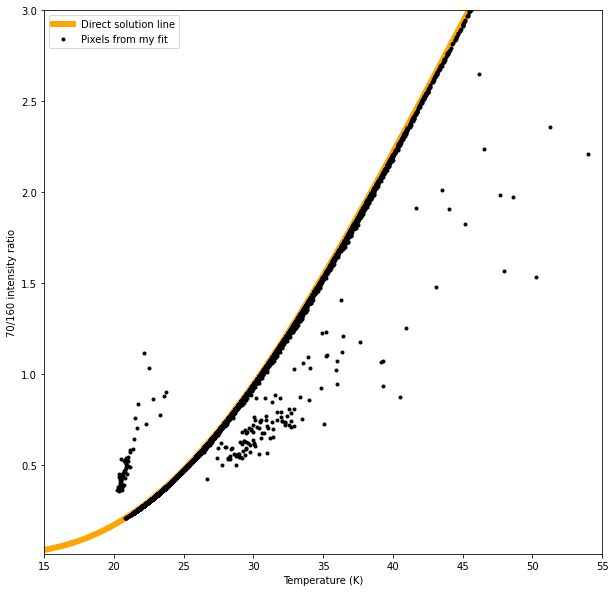

In [7]:
# NaN mask and flatten into 1D arrays
finite_mask = np.isfinite(T_img) & np.isfinite(br_img)
T_img_flat = T_img[finite_mask].flatten()
br_img_flat = br_img[finite_mask].flatten()

plt.figure(figsize=(10, 10))
plt.plot(T_thin, br_thin, lw=6, label="Direct solution line", color='orange')
plt.plot(T_img_flat, br_img_flat, 'o', markersize=3, color='k', label="Pixels from my fit")
plt.legend()
plt.xlabel("Temperature (K)"), plt.ylabel("70/160 intensity ratio")
# plt.yscale('log')#, plt.xscale('log')
plt.ylim([0.01, 3]), plt.xlim([15, 55]);

Cool! Most of the points agree with the line (which is the color-temperature approach), so the 2-band "fit" in mantipython works pretty well. There are some outlying populations, so as a good researcher, I'll locate those in the image. It looks like there are not very many pixels like this, so these should not affect our shell mass calculation.

There are 31209 pixels that follow the theoretical line to within 0.1 in ratio units.
130 pixels are too low (red) and 61 are too high (blue).
0.41% are too low.
0.19% are too high.


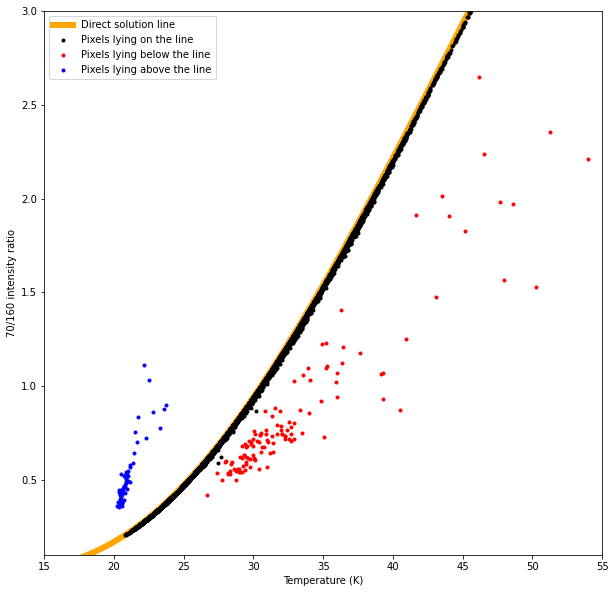

In [8]:
# Looks like the outlying points are vertically separated from the line by >0.1 (units of blue-to-red ratio)

# Fit the line (from the grid) with a spline
from scipy.interpolate import UnivariateSpline
br_thin_spline = UnivariateSpline(T_thin, br_thin, s=0)

# Make masks based on this >0.1 separation
below_line_mask = (br_thin_spline(T_img_flat) - br_img_flat) > 0.1 # plotted in red
above_line_mask = (br_img_flat - br_thin_spline(T_img_flat)) > 0.1 # plotted in blue
on_line_mask = ~(below_line_mask | above_line_mask)

print(f"There are {np.sum(on_line_mask)} pixels that follow the theoretical line to within 0.1 in ratio units.")
print(f"{np.sum(below_line_mask)} pixels are too low (red) and {np.sum(above_line_mask)} are too high (blue).")
print(f"{100.*np.sum(below_line_mask)/below_line_mask.size:.2f}% are too low.")
assert below_line_mask.size == above_line_mask.size
print(f"{100.*np.sum(above_line_mask)/above_line_mask.size:.2f}% are too high.")

plt.figure(figsize=(10, 10))
plt.plot(T_thin, br_thin, color='orange', lw=6, label='Direct solution line')
plt.plot(T_img_flat[on_line_mask], br_img_flat[on_line_mask], 'o', markersize=3,
         color='k', label="Pixels lying on the line")
plt.plot(T_img_flat[below_line_mask], br_img_flat[below_line_mask], 'o',
         markersize=3, color='r', label="Pixels lying below the line")
plt.plot(T_img_flat[above_line_mask], br_img_flat[above_line_mask], 'o',
         markersize=3, color='b', label="Pixels lying above the line")
plt.xlabel("Temperature (K)"), plt.ylabel("70/160 intensity ratio")
plt.legend()
plt.ylim([0.1, 3]), plt.xlim([15, 55]);

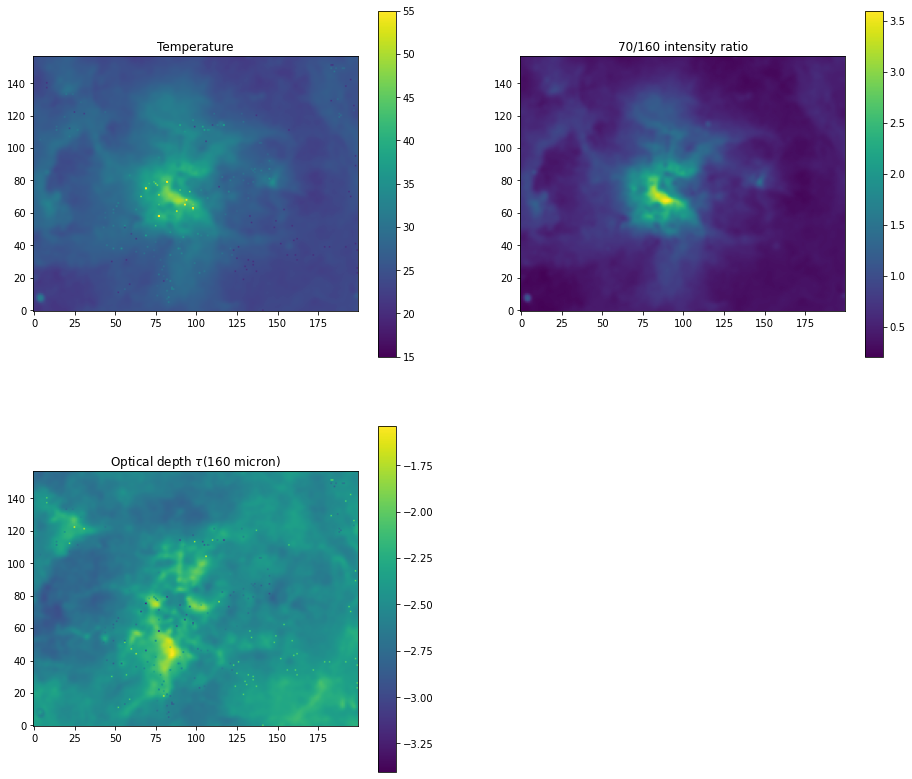

In [9]:
# Make these masks for the image (instead of the flattened, NaN-masked 1D arrays)
below_img_mask = np.zeros_like(finite_mask)
below_img_mask[finite_mask] = (br_thin_spline(T_img[finite_mask]) - br_img[finite_mask]) > 0.1
assert np.sum(below_img_mask) == np.sum(below_line_mask)

above_img_mask = np.zeros_like(finite_mask)
above_img_mask[finite_mask] = (br_img[finite_mask] - br_thin_spline(T_img[finite_mask])) > 0.1
assert np.sum(above_img_mask) == np.sum(above_line_mask)

# Plot
plt.figure(figsize=(16, 14))
plt.subplot(221)
plt.imshow(T_img, origin='lower', vmin=15, vmax=55)
plt.colorbar()
plt.title("Temperature")
plt.subplot(222)
plt.imshow(br_img, origin='lower')
plt.colorbar()
plt.title("70/160 intensity ratio")
plt.subplot(223)
plt.imshow(tau_img, origin='lower')
plt.colorbar()
plt.title("Optical depth $\\tau$(160 micron)");

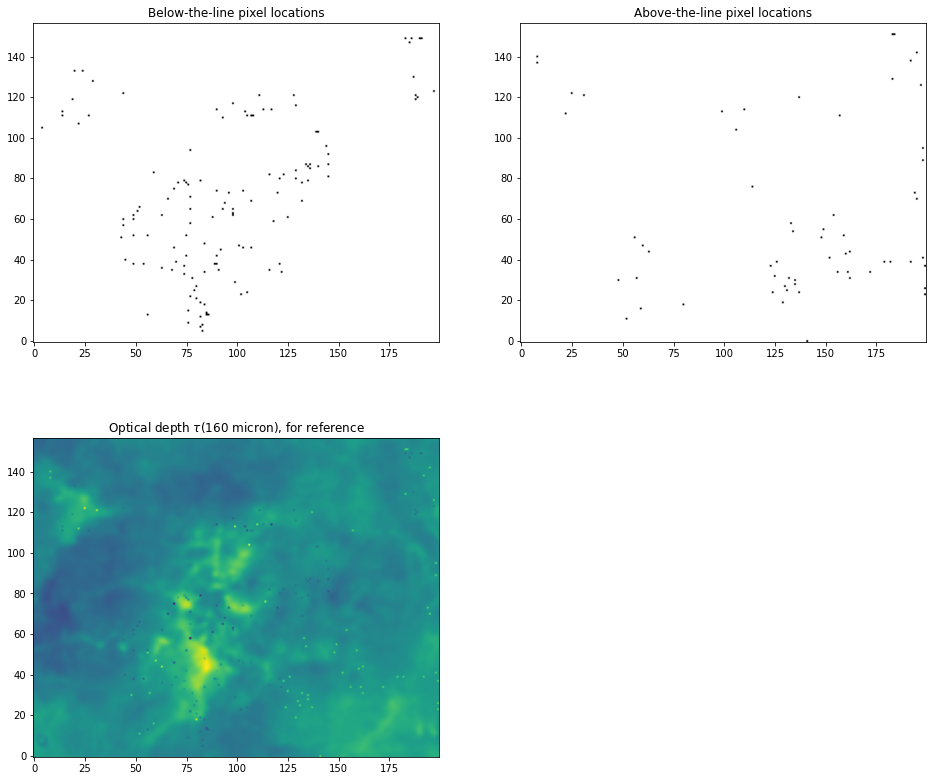

In [10]:
plt.figure(figsize=(16, 14))
plt.subplot(221)
plt.imshow(below_img_mask, origin='lower', cmap="Greys")
plt.title("Below-the-line pixel locations")
plt.subplot(222)
plt.imshow(above_img_mask, origin='lower', cmap="Greys")
plt.title("Above-the-line pixel locations")
plt.subplot(223)
plt.imshow(tau_img, origin='lower')
plt.title("Optical depth $\\tau$(160 micron), for reference");

# In conclusion,
### My "fits" to the 70 and 160 micron band intensities produce temperatures consistent with those derived from a more direct color-temperature method.
The pixels that deviate from the direct color-temperature solution are few, scattered, and not at all correlated with the shell, where we used these results to estimate the shell mass.

This was only tested on a $\beta=1.7$ fit to the 70 and 160 micron bands that I had done at the 500 micron image resolution, which is much coarser than the 160 micron image resolution at which I ran the fits for the RCW 49 paper. I expect the agreement between my fit and this direct color-temperature approach to be the same if I re-did these calculations with a grid of intensities at $\beta=2$.